# Generate Spikes for Spike Fitting

In [1]:
import numpy as np
import pandas as pd
from brian2 import *
from brian2tools import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


## Generate Data

In [2]:
dt = 0.01 * ms
defaultclock.dt = dt

# Generate a step-current input and an "experimental" voltage trace
input_current1 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt))*5, np.zeros(int(5*ms/dt))])* 5 *nA
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt))*10, np.zeros(int(5*ms/dt))]) * 5 * nA

input_current2 = np.stack((input_current0, input_current1))
I = TimedArray(input_current0, dt=dt)

In [3]:
# C = 1*nF
# gL = 30*nS
EL = -70*mV
VT = -50*mV
DeltaT = 2*mV

In [4]:
eqs = Equations('''
    dv/dt = (gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT) + I(t))/C : volt
    gL: siemens (constant)
    C: farad (constant)
    ''')

In [5]:
group = NeuronGroup(1, eqs,
                    threshold='v > -50*mV',
                    reset='v = -70*mV',
                    method='exponential_euler')
group.v = -70 *mV
group.set_states({'gL': [30*nS], 'C':[1*nF]})

monitor0 = StateMonitor(group, 'v', record=True)
smonitor0  = SpikeMonitor(group)

In [6]:
run(60*ms)

In [7]:
voltage0 = monitor0.v[0]/mV
out_spikes0 = getattr(smonitor0, 't') / ms

In [8]:
start_scope()
I = TimedArray(input_current1, dt=dt)
group1 = NeuronGroup(1, eqs,
                    threshold='v > -50*mV',
                    reset='v = -70*mV',
                    method='exponential_euler')
group1.v = -70 *mV
group1.set_states({'gL': [30*nS], 'C':[1*nF]})

monitor1 = StateMonitor(group1, 'v', record=True)
smonitor1  = SpikeMonitor(group1)

In [9]:
run(60*ms)

In [10]:
out_spikes1 = getattr(smonitor1, 't') / ms
voltage1 = monitor1.v[0]/mV

In [11]:
inp_trace0 = np.array([input_current0])
inp_trace1 = np.array([input_current1])

inp_trace = np.concatenate((inp_trace0, inp_trace1))
out_spikes = np.array([out_spikes0, out_spikes1])
print('out_spikes', out_spikes)

out_spikes [array([5.39, 5.8 , 6.21, 6.62, 7.03, 7.44, 7.85, 8.26, 8.67, 9.08, 9.49,
       9.9 ])
 array([5.79, 6.6 , 7.41, 8.22, 9.03, 9.84])]


## Save into DataFrames

In [12]:
inp_trace

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
df_inp = pd.DataFrame(data=inp_trace)
df_inp

,0,1,2,3,4,5,6,7,8,9,...,1487,1488,1489,1490,1491,1492,1493,1494,1495,1496
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
out_spikes

array([array([5.39, 5.8 , 6.21, 6.62, 7.03, 7.44, 7.85, 8.26, 8.67, 9.08, 9.49,
       9.9 ]),
       array([5.79, 6.6 , 7.41, 8.22, 9.03, 9.84])], dtype=object)

In [15]:
# out_spikes = pd.DataFrame(data=out_spikes)
# out_spikes

In [16]:
# df_inp.to_csv('input_traces_if.csv')
# df_out.to_csv('output_spikes_if.csv', mode='a')

## Load check the DF

In [17]:
# df_inp_traces = pd.read_csv('input_traces_if.csv')
# df_inp_traces

In [18]:
# inp_traces = df_inp_traces.to_numpy()
# inp_traces = inp_traces[:, 1:]
# inp_traces

In [19]:
# df_out_traces = pd.read_csv('output_spikes_if.csv')
# df_out_traces

In [20]:
# out_traces = df_out_traces.to_numpy()
# out_traces = out_traces[:4, 1:]
# out_traces[0][0]


## FIT SPIKES

In [21]:
out_spikes

array([array([5.39, 5.8 , 6.21, 6.62, 7.03, 7.44, 7.85, 8.26, 8.67, 9.08, 9.49,
       9.9 ]),
       array([5.79, 6.6 , 7.41, 8.22, 9.03, 9.84])], dtype=object)

In [22]:
np.shape(out_spikes)

(2,)

In [23]:
np.shape(inp_trace)

(2, 1497)

In [24]:
start_scope()
eqs_fit = Equations('''
    dv/dt = (gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT) + I)/C : volt
    gL: siemens (constant)
    C: farad (constant)
    ''',
    EL = -70*mV,
    VT = -50*mV,
    DeltaT = 2*mV,
    # C=1*nF
    )

In [25]:
n_opt = NevergradOptimizer('DE')
metric = GammaFactor(dt, 60*ms)


result_dict, error = fit_spikes(model=eqs_fit, input_var='I', dt=dt,
                                input=inp_trace * amp, output=out_spikes,
                                n_rounds=2, n_samples=30, optimizer=n_opt,
                                metric=metric,
                                threshold='v > -50*mV',
                                reset='v = -70*mV',
                                method='exponential_euler',
                                param_init={'v': -70*mV},
                                gL=[20*nS, 40*nS],
                                C = [0.5*nF, 1.5*nF], 
                               )

round 0 with error 1.1102230246251565e-16
parameters: {'C': 1.0046662207532012e-09, 'gL': 2.2186976354448373e-08}
round 1 with error 0.6405547226386806
parameters: {'C': 1.0046662207532012e-09, 'gL': 2.2186976354448373e-08}


In [26]:
result_dict

{'C': 1.0046662207532012e-09, 'gL': 2.2186976354448373e-08}

In [27]:
# print(result_dict, error)
print('goal:', {'gL': [30*nS], 'C':[1*nF]})
print('results:', result_dict['C']*farad, result_dict['gL']*siemens)

goal: {'gL': [30. * nsiemens], 'C': [1. * nfarad]}
results: 1.00466622 nF 22.18697635 nS


In [28]:
res = {'gL': [result_dict['gL']*siemens], 'C': [result_dict['C']*farad]}

In [29]:
# visualization of the results
start_scope()
spikes = generate_fits(model=eqs_fit,
                       params=result_dict,
                       input=inp_trace * amp,
                       input_var='I',
                       output_var='spikes',
                       dt=dt,
                       threshold='v > -50*mV',
                       reset='v = -70*mV',
                       method='exponential_euler',
                       param_init={'v': -70*mV})

print('spike times:', spikes)

spike times: [array([5.39, 5.8 , 6.21, 6.62, 7.03, 7.44, 7.85, 8.26, 8.67, 9.08, 9.49,
       9.9 ]), array([5.8 , 6.62, 7.44, 8.26, 9.08, 9.9 ])]


In [30]:
start_scope()
fits = generate_fits(model=eqs_fit,
                     params=result_dict,
                     input=inp_trace * amp,
                     input_var='I',
                     output_var='v',
                     dt=dt,
                     threshold='v > -50*mV',
                     reset='v = -70*mV',
                     method='exponential_euler',
                     param_init={'v': -70*mV})


print('fits', fits)

fits [[-70.         -69.99999998 -69.99999996 ... -66.88005843 -66.88074726
  -66.88143594]
 [-70.         -69.99999998 -69.99999996 ... -68.44003219 -68.44037661
  -68.44072096]] mV


In [31]:
start_scope()
goal = generate_fits(model=eqs_fit,
                     params={'gL': [30*nS], 'C':[1*nF]},
                     input=inp_trace * amp,
                     input_var='I',
                     output_var='v',
                     dt=dt,
                     threshold='v > -50*mV',
                     reset='v = -70*mV',
                     method='exponential_euler',
                     param_init={'v': -70*mV})


print('goal', goal)

goal [[-70.         -69.99999997 -69.99999995 ... -66.98700554 -66.98790918
  -66.98881255]
 [-70.         -69.99999997 -69.99999995 ... -67.20473715 -67.20557549
  -67.20641358]] mV


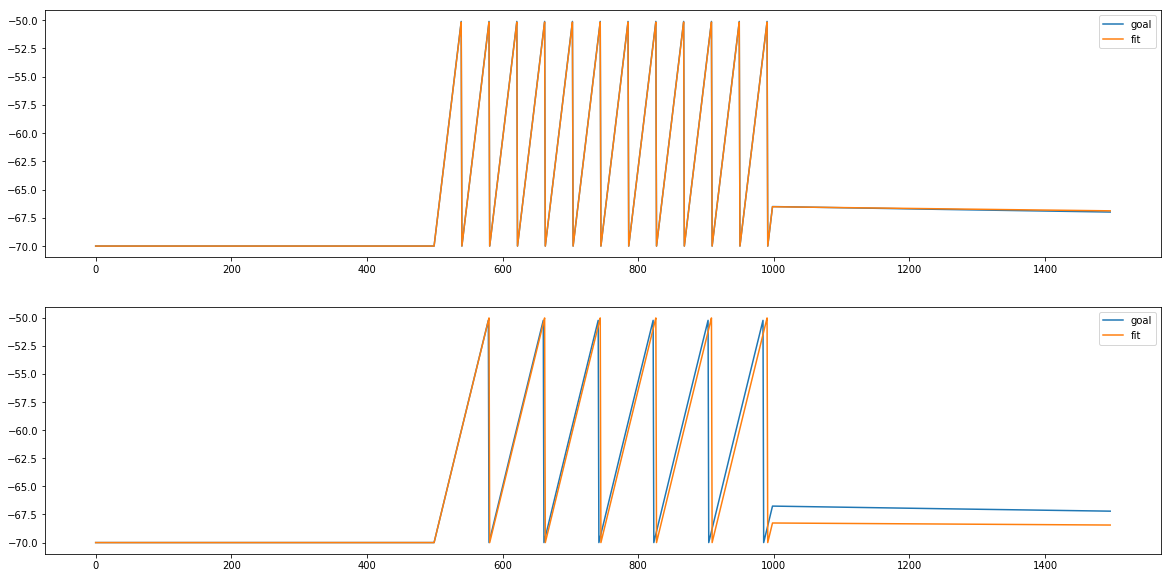

In [32]:
fig, ax = plt.subplots(nrows=2, figsize=(20,10))
ax[0].plot(goal[0]/mV, label='goal');
ax[0].plot(fits[0]/mV, label='fit');
ax[1].plot(goal[1]/mV, label='goal');
ax[1].plot(fits[1]/mV, label='fit');

ax[0].legend()
ax[1].legend()

plt.show()